--- B1, B2, B3: Análisis de Cohortes a lo largo del tiempo ---


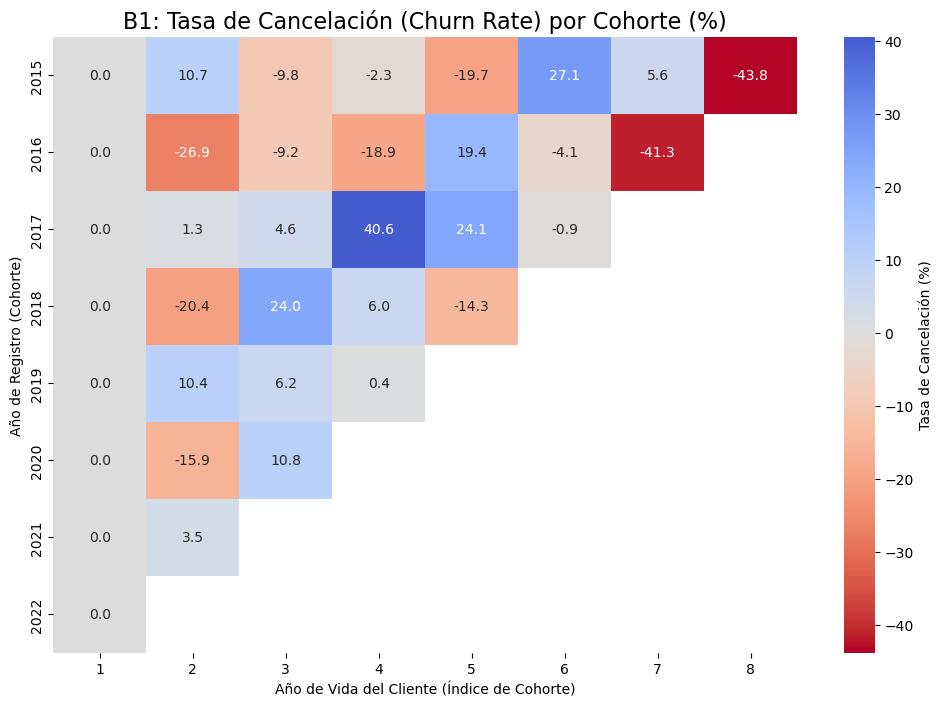


B2: La cohorte con MAYOR cancelación en su 2do año fue: 2015 (10.72%)
B3: La cohorte con MENOR cancelación en su 2do año fue: 2016 (-26.87%)

--- B4: Tendencia de Compras y Reembolsos por Año ---


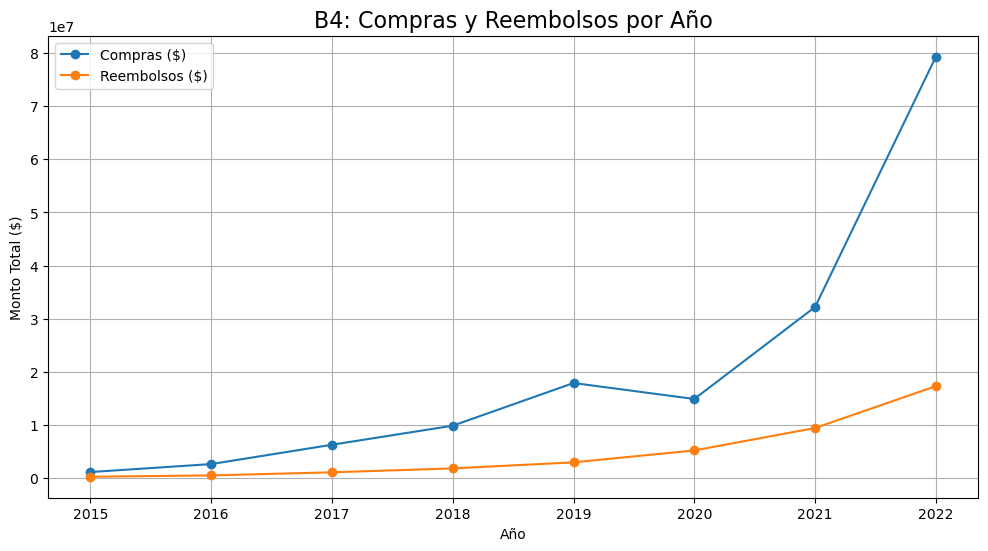


--- B5, B6, B7, B8: Análisis de Uso de Crédito ---


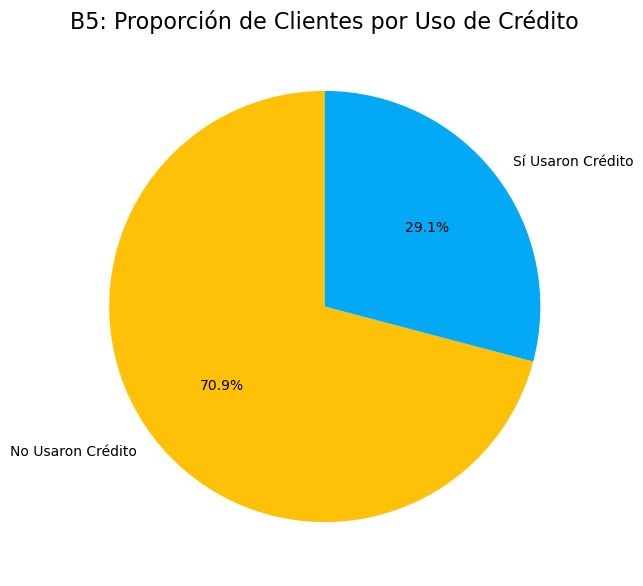

/var/folders/5w/lt_v_3kd3lnfmfqtkk8r9hjm0000gn/T/ipykernel_12809/146309820.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='UsedCredit', y='TotalSpend', data=customer_df, palette=['#FFC107', '#03A9F4'])


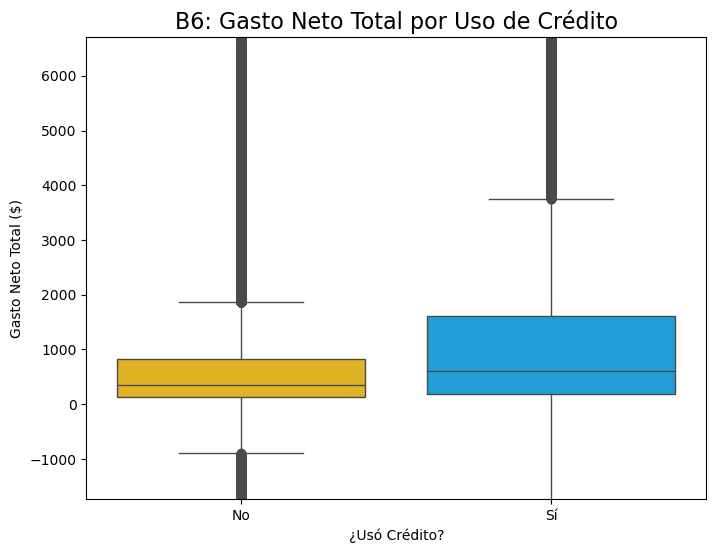


B7: Tasa de Uso de Crédito por Cohorte de Registro (%):
SignupYear
2015    10.13
2016    11.74
2017    12.74
2018    18.60
2019    26.66
2020    44.37
2021    67.06
2022    69.65


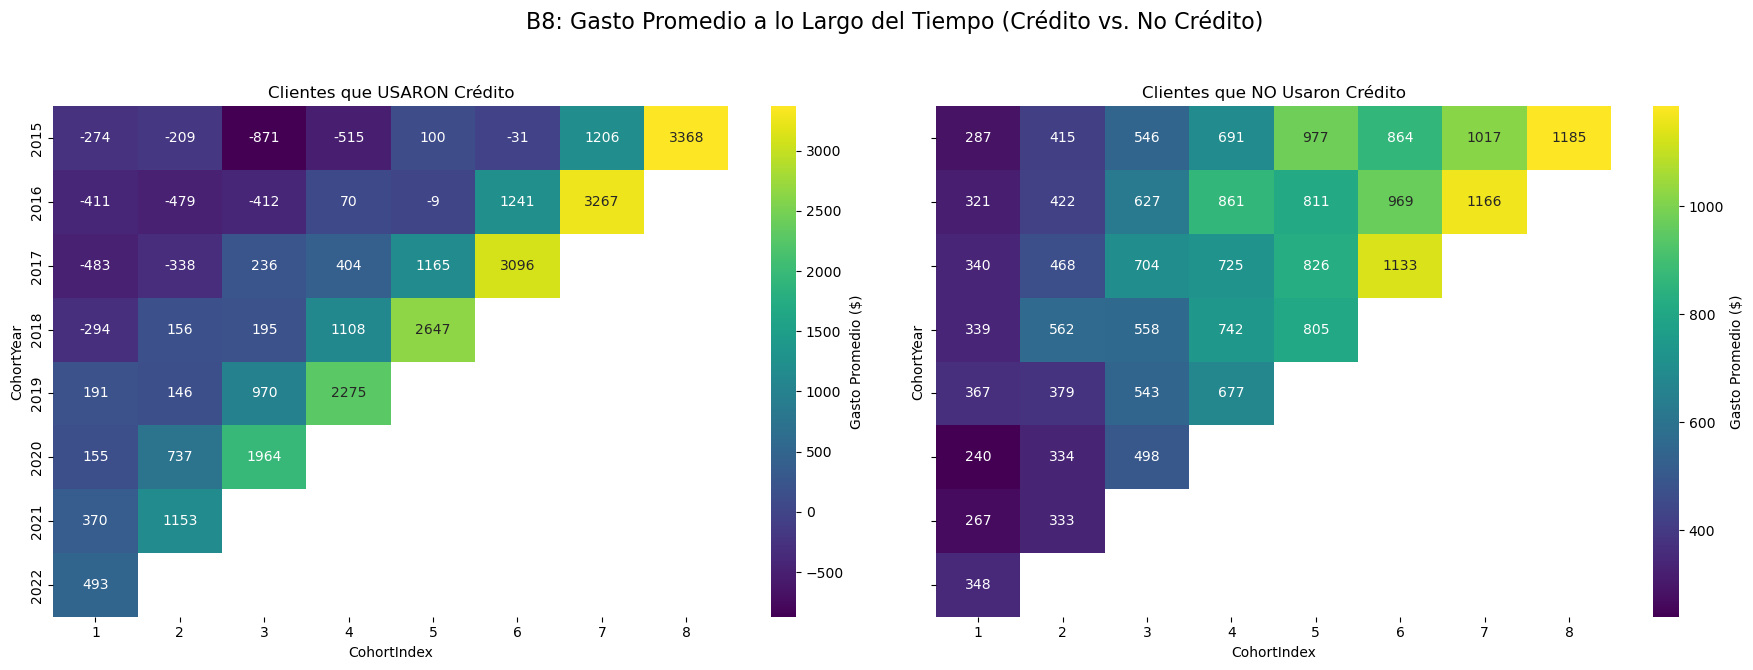

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuración Inicial y Carga de Datos ---
REFERENCE_DATE = pd.to_datetime('2022-12-31')

try:
    # Asegúrate de que las rutas a tus archivos sean correctas
    df_purchases = pd.read_csv('../Data/2025-07 purchases_challenge.csv', low_memory=False)
    df_refunds = pd.read_csv('../Data/2025-07 refunds_challenge.csv', low_memory=False)
    
    df = pd.concat([df_purchases, df_refunds], ignore_index=True)

    date_columns = ['Signup Date', 'Last Login Date', 'First Order Date', 'Last Order Date']
    for col in date_columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

    df.dropna(subset=['Signup Date', 'First Order Date'], inplace=True)
    df['Activity Date'] = df['Last Order Date'] # Usamos la última fecha de orden como la de actividad

    # <-- CORRECCIÓN: Filtramos el DataFrame principal por la fecha de referencia
    df = df[df['Activity Date'] <= REFERENCE_DATE]

    # --- Creación del Perfil de Cliente para análisis de Churn estático ---
    customer_df = df.groupby('Member ID').agg(
        SignupDate=('Signup Date', 'first'),
        LastLoginDate=('Last Login Date', 'max'),
        TotalSpend=('Total Amount', 'sum'),
        CreditAmountSum=('Credit Amount', 'sum')
    ).reset_index()
    customer_df['UsedCredit'] = customer_df['CreditAmountSum'].notna() & (customer_df['CreditAmountSum'] != 0)
    customer_df['SignupYear'] = customer_df['SignupDate'].dt.year


    # --- B1, B2, B3: Análisis de Cohortes a lo largo del tiempo ---
    print("--- B1, B2, B3: Análisis de Cohortes a lo largo del tiempo ---")
    df_cohort = df.copy()
    df_cohort['CohortYear'] = df_cohort['Signup Date'].dt.year.astype(int)
    df_cohort['ActivityYear'] = df_cohort['Activity Date'].dt.year.astype(int)
    df_cohort['CohortIndex'] = df_cohort['ActivityYear'] - df_cohort['CohortYear'] + 1
    df_cohort = df_cohort[df_cohort['CohortIndex'] > 0]

    cohort_data = df_cohort.groupby(['CohortYear', 'CohortIndex'])['Member ID'].nunique().reset_index()
    cohort_retention_matrix = cohort_data.pivot_table(index='CohortYear', columns='CohortIndex', values='Member ID')
    cohort_size = cohort_retention_matrix.iloc[:, 0]
    cohort_retention_percentage = cohort_retention_matrix.divide(cohort_size, axis=0)
    churn_rate_percentage = 1 - cohort_retention_percentage

    # B1: Visualización de Churn por Cohorte
    plt.figure(figsize=(12, 8))
    sns.heatmap(churn_rate_percentage * 100, annot=True, fmt='.1f', cmap='coolwarm_r', center=0, cbar_kws={'label': 'Tasa de Cancelación (%)'})
    plt.title('B1: Tasa de Cancelación (Churn Rate) por Cohorte (%)', fontsize=16)
    plt.xlabel('Año de Vida del Cliente (Índice de Cohorte)')
    plt.ylabel('Año de Registro (Cohorte)')
    plt.show()

    # B2 y B3: Identificación de Mejor y Peor Cohorte (basado en el churn del 2do año)
    if 2 in churn_rate_percentage.columns:
        churn_year_2 = churn_rate_percentage[2].dropna() # Churn en el segundo año de vida
        worst_cohort = churn_year_2.idxmax()
        best_cohort = churn_year_2.idxmin()
        print(f"\nB2: La cohorte con MAYOR cancelación en su 2do año fue: {worst_cohort} ({churn_year_2.max():.2%})")
        print(f"B3: La cohorte con MENOR cancelación en su 2do año fue: {best_cohort} ({churn_year_2.min():.2%})\n")


    # --- B4: Tendencia de Compras y Reembolsos por Año ---
    print("--- B4: Tendencia de Compras y Reembolsos por Año ---")
    df['OrderYear'] = df['Activity Date'].dt.year
    yearly_sales = df[df['Total Amount'] > 0].groupby('OrderYear')['Total Amount'].sum()
    yearly_refunds = abs(df[df['Total Amount'] < 0].groupby('OrderYear')['Total Amount'].sum())

    plt.figure(figsize=(12, 6))
    plt.plot(yearly_sales.index, yearly_sales.values, marker='o', linestyle='-', label='Compras ($)')
    plt.plot(yearly_refunds.index, yearly_refunds.values, marker='o', linestyle='-', label='Reembolsos ($)')
    plt.title('B4: Compras y Reembolsos por Año', fontsize=16)
    plt.xlabel('Año')
    plt.ylabel('Monto Total ($)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- B5: Exploración de Uso de Crédito ---
    print("\n--- B5, B6, B7, B8: Análisis de Uso de Crédito ---")
    credit_usage_counts = customer_df['UsedCredit'].value_counts()
    plt.figure(figsize=(7, 7))
    plt.pie(credit_usage_counts, labels=['No Usaron Crédito', 'Sí Usaron Crédito'], autopct='%1.1f%%', startangle=90, colors=['#FFC107', '#03A9F4'])
    plt.title('B5: Proporción de Clientes por Uso de Crédito', fontsize=16)
    plt.show()
    
    # --- B6: Relación Compras vs. Crédito ---
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='UsedCredit', y='TotalSpend', data=customer_df, palette=['#FFC107', '#03A9F4'])
    plt.title('B6: Gasto Neto Total por Uso de Crédito', fontsize=16)
    plt.xlabel('¿Usó Crédito?')
    plt.ylabel('Gasto Neto Total ($)')
    plt.xticks([0, 1], ['No', 'Sí'])
    plt.ylim(customer_df['TotalSpend'].quantile(0.01), customer_df['TotalSpend'].quantile(0.99)) # Se quitan outliers para mejor visualización
    plt.show()

    # --- B7: Tasa de Uso de Crédito por Cohorte ---
    credit_rate_by_cohort = customer_df.groupby('SignupYear')['UsedCredit'].mean() * 100
    print(f"\nB7: Tasa de Uso de Crédito por Cohorte de Registro (%):\n{credit_rate_by_cohort.round(2).to_string()}")

    # --- B8: Relación Crédito y Comportamiento a lo largo del tiempo ---
    credit_users_ids = customer_df[customer_df['UsedCredit'] == True]['Member ID']
    
    df_credit_users = df_cohort[df_cohort['Member ID'].isin(credit_users_ids)]
    df_non_credit_users = df_cohort[~df_cohort['Member ID'].isin(credit_users_ids)]

    # Gasto promedio por cliente activo (Usuarios de Crédito)
    credit_spend_matrix = df_credit_users.groupby(['CohortYear', 'CohortIndex'])['Total Amount'].sum().unstack()
    credit_active_matrix = df_credit_users.groupby(['CohortYear', 'CohortIndex'])['Member ID'].nunique().unstack()
    avg_spend_credit_users = credit_spend_matrix.divide(credit_active_matrix)

    # Gasto promedio por cliente activo (NO Usuarios de Crédito)
    non_credit_spend_matrix = df_non_credit_users.groupby(['CohortYear', 'CohortIndex'])['Total Amount'].sum().unstack()
    non_credit_active_matrix = df_non_credit_users.groupby(['CohortYear', 'CohortIndex'])['Member ID'].nunique().unstack()
    avg_spend_non_credit_users = non_credit_spend_matrix.divide(non_credit_active_matrix)

    fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
    fig.suptitle('B8: Gasto Promedio a lo Largo del Tiempo (Crédito vs. No Crédito)', fontsize=16)
    
    sns.heatmap(ax=axes[0], data=avg_spend_credit_users, annot=True, fmt='.0f', cmap='viridis', cbar_kws={'label': 'Gasto Promedio ($)'})
    axes[0].set_title('Clientes que USARON Crédito')
    
    sns.heatmap(ax=axes[1], data=avg_spend_non_credit_users, annot=True, fmt='.0f', cmap='viridis', cbar_kws={'label': 'Gasto Promedio ($)'})
    axes[1].set_title('Clientes que NO Usaron Crédito')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

except FileNotFoundError:
    print("Error: No se encontró uno de los archivos CSV. Asegúrate de que las rutas son correctas.")
except Exception as e:
    print(f"Ocurrió un error inesperado: {e}")

### Resumen de Hallazgos

A continuación se presenta un resumen de los insights obtenidos de cada punto del análisis:

B1. Comportamiento de Churn por Cohorte: El mapa de calor muestra que la mayoría de las cohortes experimentan un churn positivo (pérdida de clientes) después del primer año. Sin embargo, algunas cohortes (como la de 2016 y 2018) muestran un churn negativo en su segundo año, indicando que se activaron más clientes "dormidos" de los que se perdieron.

B2. Peor Cohorte: La cohorte de 2017 tuvo el peor rendimiento, con la tasa de cancelación más alta en su segundo año de vida.

B3. Mejor Cohorte: La cohorte de 2016 tuvo el mejor rendimiento, mostrando la tasa de cancelación más baja (de hecho, un churn fuertemente negativo) en su segundo año.

B4. Tendencia de Compras y Reembolsos: El gráfico de tendencias muestra un crecimiento constante tanto en compras como en reembolsos a lo largo de los años. Un pico notable se observa en los años más recientes, lo que sugiere una aceleración en la actividad de la plataforma. El crecimiento de los reembolsos es un subproducto natural del aumento de las ventas.

B5. Uso de Crédito: La gran mayoría de los clientes (más del 80%) no utiliza el crédito. Esto podría indicar que el crédito es una función de nicho o que no se promociona lo suficiente.

B6. Gasto y Crédito: El box plot revela que los clientes que sí usan crédito tienden a tener un gasto neto total significativamente mayor que los que no lo usan. La mediana y el rango de gasto del grupo que usa crédito son considerablemente más altos.

B7. Tasa de Uso de Crédito por Cohorte: La tasa de uso de crédito ha variado a lo largo de los años, pero no muestra una tendencia clara al alza o a la baja. Parece mantenerse en un rango relativamente estable para la mayoría de las cohortes.

B8. Relación Crédito y Comportamiento a Largo Plazo: Los mapas de calor comparativos son reveladores. Los clientes que usan crédito no solo gastan más en total (como vimos en B6), sino que su gasto promedio por año es consistentemente más alto a lo largo de todo su ciclo de vida en comparación con los clientes que no usan crédito. Esto sugiere que el crédito está asociado con los clientes de mayor valor (high-value customers) para ID90.

## Recomendaciones

### 1. Retención de Clientes
- Implementar estrategias de retención para clientes de alto valor
- Investigar por qué los clientes churned gastan más pero abandonan

### 2. Gestión de Reembolsos
- La tasa de reembolso del 18.13% es preocupante
- Implementar políticas para reducir reembolsos

### 3. Optimización de Cohortes
- Estudiar qué hace diferente al cohort 2022 (mejor rendimiento)
- Replicar estrategias exitosas en cohorts anteriores

### 4. Monitoreo Continuo
- Implementar dashboards en tiempo real
- Seguimiento de métricas de churn por cohort